### U-net with simple Resnet Blocks
#### update log
1. Correct the errors to in function iou_metric,  use "my_iou_metric" to moniter the training
2. Use image size 101 x 101, no resizing
3. Last layer dropout reduced by half
4. replace conv2D with 2 basic resnet blocks in each level of U-net
5.  Use faster rle_encode (> 10 times fater than RLenc ) from (https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss)
6. set  random_state= 1234 

Reference kernels:

https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/tgibbons/u-net-without-resizing-images

https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss

The results seems not reproducible,  sometimes good (best around IOU0.79 ), sometimes  not as good!
Any suggestions to improve the results?

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="1"

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

Using TensorFlow backend.


In [2]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1

basicpath = '../data/'
path_train_images = basicpath + 'train/'
path_train_masks = basicpath + 'masks/'
path_test_images = basicpath + 'test/'



In [3]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("../data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
train_df["images"] = [np.array(load_img("../data/train/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("../data/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

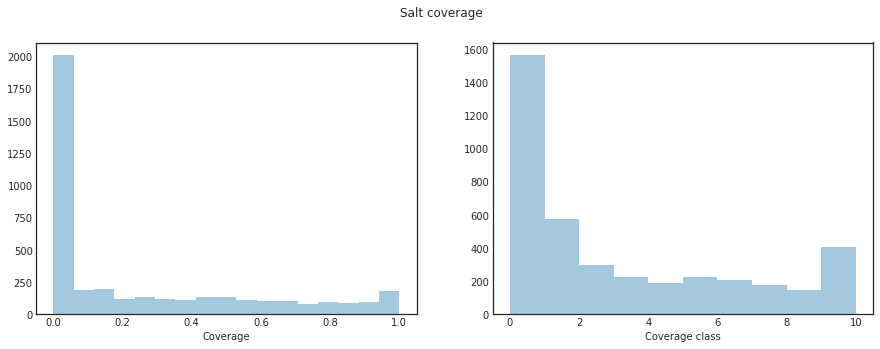

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

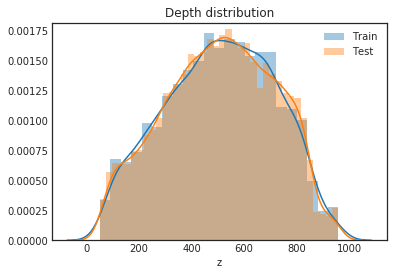

In [8]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [9]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [10]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


In [11]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [12]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [13]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [14]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [15]:
early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=40, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)
#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 91s 14ms/step - loss: 0.3752 - acc: 0.8519 - val_loss: 0.4249 - val_acc: 0.8522

Epoch 00001: val_acc improved from -inf to 0.85224, saving model to ./unet_best1.model
Epoch 2/200
6400/6400 [==============================] - 44s 7ms/step - loss: 0.2804 - acc: 0.8971 - val_loss: 0.2924 - val_acc: 0.8975

Epoch 00002: val_acc improved from 0.85224 to 0.89749, saving model to ./unet_best1.model
Epoch 3/200
6400/6400 [==============================] - 49s 8ms/step - loss: 0.2462 - acc: 0.9089 - val_loss: 0.3736 - val_acc: 0.8638

Epoch 00003: val_acc did not improve from 0.89749
Epoch 4/200
6400/6400 [==============================] - 50s 8ms/step - loss: 0.2223 - acc: 0.9179 - val_loss: 0.2157 - val_acc: 0.9271

Epoch 00004: val_acc improved from 0.89749 to 0.92713, saving model to ./unet_best1.model
Epoch 5/200
6400/6400 [==============================] - 50s 8ms/step - loss: 0.2098 - 


Epoch 00040: val_acc did not improve from 0.95777
Epoch 41/200
6400/6400 [==============================] - 50s 8ms/step - loss: 0.0799 - acc: 0.9696 - val_loss: 0.1300 - val_acc: 0.9536

Epoch 00041: val_acc did not improve from 0.95777
Epoch 42/200
6400/6400 [==============================] - 50s 8ms/step - loss: 0.0805 - acc: 0.9693 - val_loss: 0.1299 - val_acc: 0.9535

Epoch 00042: val_acc did not improve from 0.95777
Epoch 43/200
6400/6400 [==============================] - 44s 7ms/step - loss: 0.0759 - acc: 0.9718 - val_loss: 0.1269 - val_acc: 0.9558

Epoch 00043: val_acc did not improve from 0.95777
Epoch 44/200
6400/6400 [==============================] - 50s 8ms/step - loss: 0.0767 - acc: 0.9713 - val_loss: 0.1282 - val_acc: 0.9574

Epoch 00044: val_acc did not improve from 0.95777

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 45/200
6400/6400 [==============================] - 51s 8ms/step - loss: 0.0773 - acc: 0.9704 - val_loss: 0.1268 - val_acc: 0.

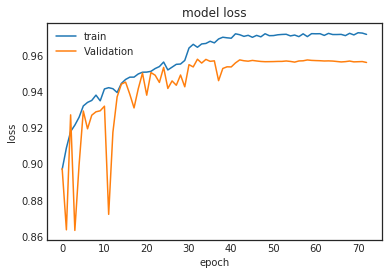

In [16]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()


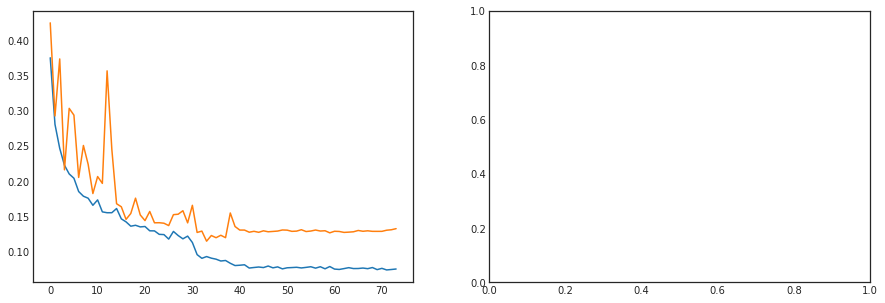

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [18]:
model = load_model("./unet_best1.model")

In [19]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [20]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [21]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])


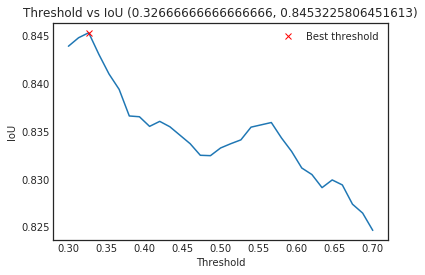

In [22]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [23]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [24]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

9

In [25]:
x_test = np.array([(np.array(load_img("../data/test/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

In [26]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 12.428476572036743 s


In [27]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [28]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,1 29 102 29 203 29 304 29 405 29 506 24 607 19...
64dba827d6,
0a3a8a5f37,
329563756f,1 5150 5152 99 5253 98 5354 98 5455 97 5556 96...
f6cba2e890,
